In [1]:
%pip install autodistill \
autodistill-grounded-sam \
supervision==0.11

  Using cached autodistill_grounded_sam-0.1.1-py3-none-any.whl (4.5 kB)
  Using cached rf_segment_anything-1.0-py3-none-any.whl (36 kB)
  Using cached rf_groundingdino-0.1.2-py2.py3-none-any.whl
  Using cached pycocotools-2.0.6-cp39-cp39-win_amd64.whl
  Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Using cached safetensors-0.3.1-cp39-cp39-win_amd64.whl (263 kB)
  Using cached regex-2023.6.3-cp39-cp39-win_amd64.whl (268 kB)
  Using cached tokenizers-0.13.3-cp39-cp39-win_amd64.whl (3.5 MB)
  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
  Attempting uninstall: supervision
    Found existing installation: supervision 0.9.0
    Uninstalling supervision-0.9.0:
      Successfully uninstalled supervision-0.9.0
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\isnob\Documents\workspace\YoloGP\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
%pip install tqdm ipywidgets

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\isnob\Documents\workspace\YoloGP\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [45]:
import os
import torch
print(torch.cuda.is_available())
HOME = os.getcwd()
print(HOME)
!nvidia-smi

True
c:\Users\isnob\Documents\workspace\YoloGP\notebooks
Sun Jul 30 18:31:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| 32%   59C    P2              80W / 200W |   7883MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+----------

In [46]:
from dataclasses import dataclass
import glob
from autodistill_grounded_sam import GroundedSAM
from autodistill_grounded_sam.helpers import combine_detections

import supervision as sv
from groundingdino.util.inference import Model
from segment_anything import SamPredictor
import cv2
import numpy as np
from autodistill.detection import CaptionOntology, DetectionBaseModel
from autodistill.helpers import split_data

from autodistill_grounded_sam.helpers import (
    combine_detections,
    load_grounding_dino,
    load_SAM
)
from tqdm import tqdm_notebook
# Yield successive n-sized
# chunks from l.
def divide_chunks(l, n):

    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]

@dataclass
class GroundedSAMv2(GroundedSAM):
    grounding_dino_model: Model
    sam_predictor: SamPredictor
    box_threshold: float
    text_threshold: float

    def __init__(self, ontology: CaptionOntology, box_threshold=0.35, text_threshold=0.25,load_san=True):
        self.ontology = ontology
        self.grounding_dino_model = load_grounding_dino()
        if load_san:
            self.sam_predictor = load_SAM()
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold

    def predict(self, input: str, segment:bool=True) -> sv.Detections:
        image = cv2.imread(input)

        # GroundingDINO predictions
        detections_list = []

        for i, description in enumerate(self.ontology.prompts()):
            # detect objects
            detections = self.grounding_dino_model.predict_with_classes(
                image=image,
                classes=[description],
                box_threshold=self.box_threshold,
                text_threshold=self.text_threshold,
            )

            detections_list.append(detections)

        detections = combine_detections(
            detections_list, overwrite_class_ids=range(len(detections_list))
        )

        # SAM Predictions
        xyxy = detections.xyxy
        if segment:
            self.sam_predictor.set_image(image)
            result_masks = []
            for box in xyxy:
                masks, scores, logits = self.sam_predictor.predict(
                    box=box, multimask_output=False
                )
                index = np.argmax(scores)
                result_masks.append(masks[index])

            detections.mask = np.array(result_masks)

        # separate in supervision to combine detections and override class_ids
        return detections
    
    def label(
        self, input_folder: str, extension: str = ".jpg", output_folder: str = None, segment=False
    ) -> sv.DetectionDataset:
        if output_folder is None:
            output_folder = input_folder + "_labeled"

        os.makedirs(output_folder, exist_ok=True)

        images_map = {}
        detections_map = {}

        files = glob.glob(input_folder + "/*" + extension)
        progress_bar = tqdm_notebook(files, desc="Labeling images")
        # iterate through images in input_folder
        for f_path in progress_bar:
            progress_bar.set_description(desc=f"Labeling {f_path}", refresh=True)
            image = cv2.imread(f_path)

            f_path_short = os.path.basename(f_path)
            images_map[f_path_short] = image.copy()
            detections = self.predict(f_path,segment=segment)
            detections_map[f_path_short] = detections

        dataset = sv.DetectionDataset(
            self.ontology.classes(), images_map, detections_map
        )

        dataset.as_yolo(
            output_folder + "/images",
            output_folder + "/annotations",
            min_image_area_percentage=0.01,
            data_yaml_path=output_folder + "/data.yaml",
        )

        split_data(output_folder)

        print("Labeled dataset created - ready for distillation.")
        return dataset

In [47]:
from autodistill.detection import CaptionOntology
from autodistill_grounded_sam import GroundedSAM

ontology=CaptionOntology({
    "curb": "curb",
    "helmet":"helmet",
    "boots":"boots",
    "gloves":"gloves",
    "rider": "rider",
    "motorcycle wheel":"wheel",
    "motorcycle":"motorcycle",
    "road":"road"
})
base_model = GroundedSAMv2(ontology=ontology)

trying to load grounding dino directly


final text_encoder_type: bert-base-uncased


['helmet', 'rider', 'wheel', 'motorcycle']
214


C:\Users\isnob\AppData\Local\Temp\ipykernel_35228\925971300.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for im in tqdm(imgs[1:5]):


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\isnob\Documents\workspace\YoloGP\notebooks\..\dataset\imola_sbk\image_00002.jpg


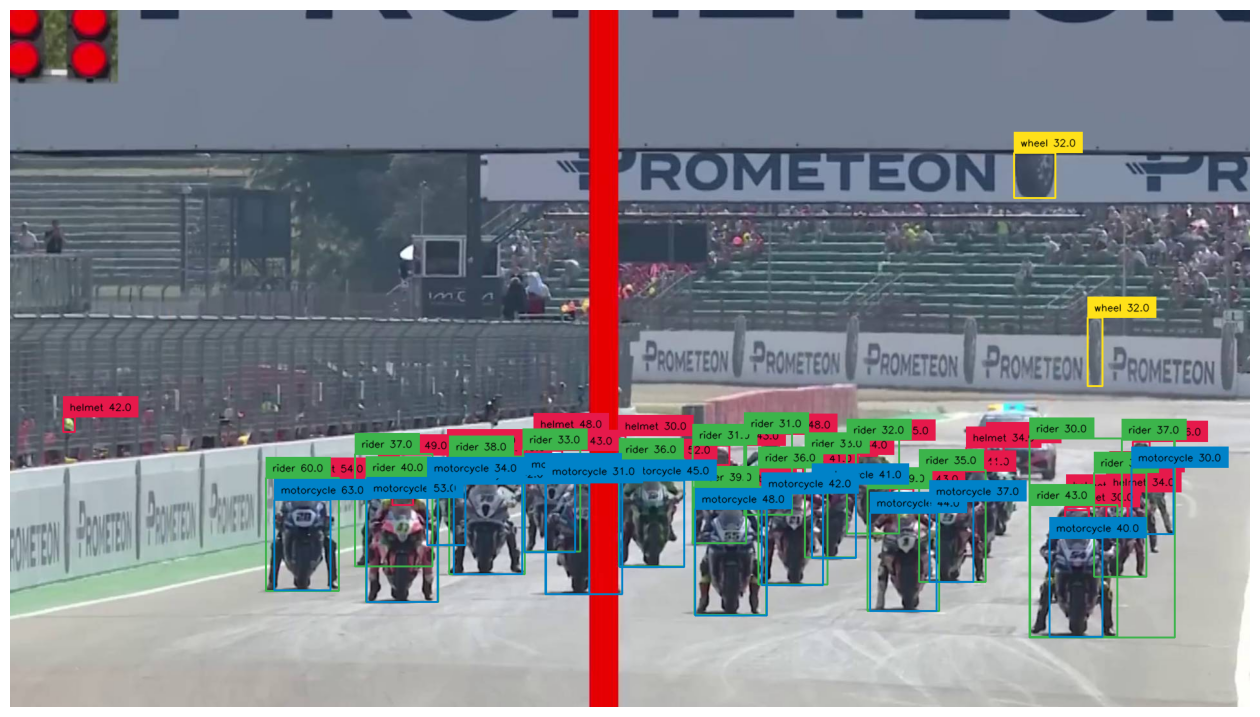

c:\Users\isnob\Documents\workspace\YoloGP\notebooks\..\dataset\imola_sbk\image_00003.jpg


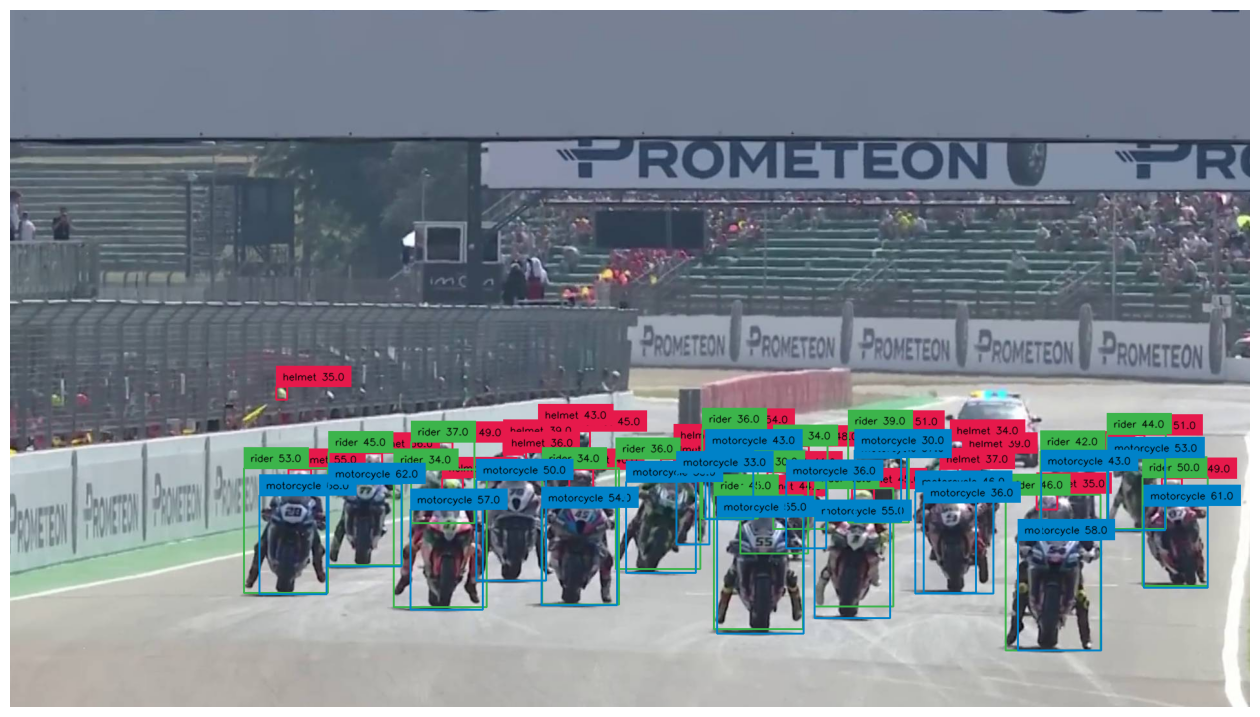

c:\Users\isnob\Documents\workspace\YoloGP\notebooks\..\dataset\imola_sbk\image_00004.jpg


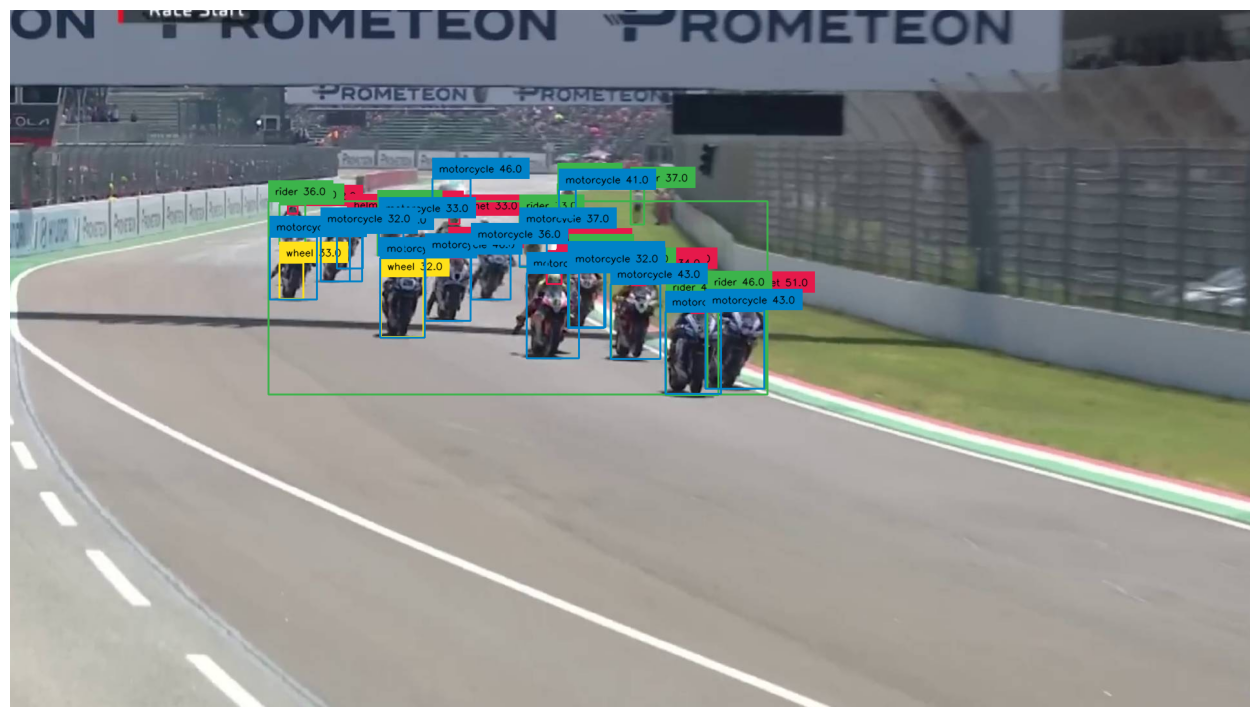

c:\Users\isnob\Documents\workspace\YoloGP\notebooks\..\dataset\imola_sbk\image_00005.jpg


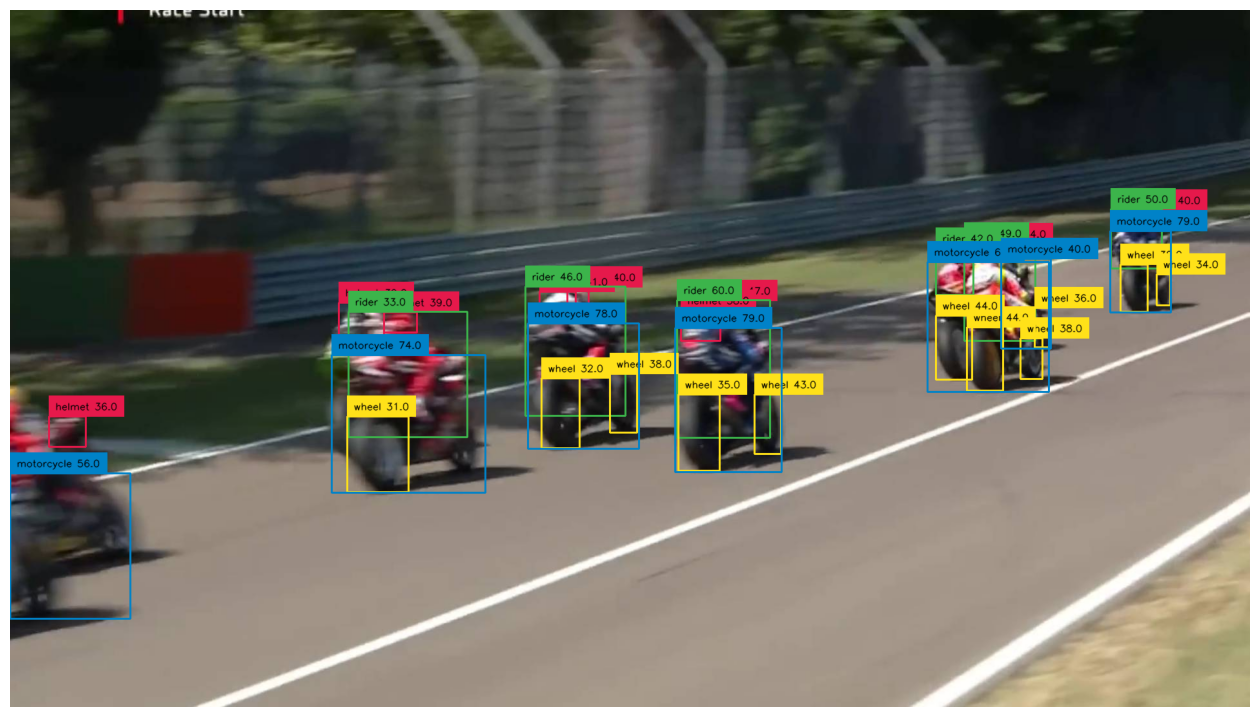

In [44]:
import cv2
import supervision as sv
from supervision import Detections
from tqdm import tqdm_notebook as tqdm

SOURCE_IMAGE_PATH="../dataset/imola_sbk/"
ontology=CaptionOntology({
   # "road curb": "curb",
   "helmet":"helmet",
    #"boots":"boots",
    #"hand gloves":"gloves",
    #"motorcycle sign sticker":"number",
    #"hand gloves": "hands",
    "rider": "rider",
    "wheel":"wheel",
    "motorbike":"motorcycle",
   # "road":"road"
})
classes=ontology.classes()
print(classes)
base_model.ontology=ontology
base_model.box_threshold = 0.3
base_model.text_threshold = 0.45

imgs = sv.list_files_with_extensions(directory=SOURCE_IMAGE_PATH)

print(len(imgs))

for im in tqdm(imgs[1:5]):
  im_path=str(im.absolute())
  print(im_path)
  image = cv2.imread(im_path)
  detections = base_model.predict(input=im_path,segment=False)
  #print(detections)
  box_annotator = sv.BoxAnnotator()
  mask_annotator = sv.MaskAnnotator()
  labels=[f"{classes[cls_id]} {round(confidence*100,0)}" for xyxy,
    mask,
    confidence,
    cls_id,
    tracker_id
 in detections]
  image = mask_annotator.annotate(scene=image, detections=detections, opacity=0.6)
  image = box_annotator.annotate(scene=image, detections=detections,labels=labels)
  h, w, c = image.shape
  #image = image[0:h, 220:w]
  sv.plot_image(image, (16, 16))

In [43]:
dataset=base_model.label(input_folder=SOURCE_IMAGE_PATH,output_folder=f"{SOURCE_IMAGE_PATH}_OUT")

C:\Users\isnob\AppData\Local\Temp\ipykernel_35228\1014558909.py:87: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(files, desc="Labeling images")


Labeling images:   0%|          | 0/213 [00:00<?, ?it/s]

c:\Users\isnob\Documents\workspace\YoloGP\venv\lib\site-packages\transformers\modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\isnob\Documents\workspace\YoloGP\venv\lib\site-packages\torch\utils\checkpoint.py:426: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\isnob\Documents\workspace\YoloGP\venv\lib\site-packages\torch\utils\checkpoint.py:59: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


KeyboardInterrupt: 